In [1]:
import numpy as np
import time
import viser
import mediapy as media

import torch
from einops import einsum

server = viser.ViserServer()
server.gui.configure_theme(dark_mode=True)

server.scene.add_frame("origin")
server.scene.set_up_direction((0., 1., 0.))

position_slider = server.gui.add_vector3(
    "Position",
    initial_value=(0, 0, 0),
    min=(-5, -5, -5),
    max=(5, 5, 5),
)
radius_slider = server.gui.add_slider(
    "Radius",
    min=0,
    max=5,
    step=0.1,
    initial_value=1
)

resolution_slider = server.gui.add_slider(
    "Resolution", min=64, max=1024, step=64, initial_value=256
)
fov_slider = server.gui.add_slider(
    "FOV", min=30, max=170, step=10, initial_value=60
)
trace_iter_slider = server.gui.add_slider(
    "Trace Iters", min=1, max=200, step=1, initial_value=20
)

╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8080   │
│   Websocket │ ws://localhost:8080     │
│             ╵                         │
╰───────────────────────────────────────╯

In [2]:
while not list(server.get_clients().values()):
    time.sleep(0.5)

client = list(server.get_clients().values())[-1]
camera = client.camera
# camera.position = (0., 0., 0.)
# # Point camera "down" x-axis
# # camera.wxyz = (1., 0., 0, 0.)

@fov_slider.on_update
def _(_) -> None:
    camera.fov = fov_slider.value * np.pi / 180

camera.position, camera.wxyz


(viser) Connection opened (0, 1 total), 14 persistent messages

(array([3., 3., 3.]),
 array([ 0.27984814,  0.88047624,  0.1159169 , -0.3647052 ]))

In [3]:
def qvec2rotmat(qvec):
    return torch.tensor(
        [
            [
                1 - 2 * qvec[2] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
                2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2],
            ],
            [
                2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1],
            ],
            [
                2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
                2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[2] ** 2,
            ],
        ],
        dtype=torch.float32,
        device="cuda",
    )

def get_c2w(camera):
    c2w = torch.eye(4, dtype=torch.float32)
    c2w[:3, :3] = qvec2rotmat(camera.wxyz)
    c2w[:3, 3] = camera.position
    return c2w

def get_w2c(camera):
    c2w = get_c2w(camera)
    w2c = torch.linalg.inv(c2w)
    return w2c

In [4]:
def get_updated_camera_intrinsics():
    W = resolution_slider.value
    H = int(W / camera.aspect)
    focal_x = W / 2 / np.tan(camera.fov/2)
    focal_y = H / 2 / np.tan(camera.fov/2)

    return W, H, focal_x, focal_y

def get_updated_camera_extrinsics():
    rot_c2w = torch.tensor(camera.wxyz, device="cuda").view(1, 4)
    
    return rot_c2w

In [5]:
def sphere_sdf(points):
    pos = torch.tensor(position_slider.value, device="cuda")
    radius = radius_slider.value

    return torch.norm(points - pos, dim=-1) - radius

def sphere_normal(points):
    eps = 1e-8
    sdf = sphere_sdf(points)
    sdf_dx = sphere_sdf(points + torch.tensor([eps, 0, 0], device="cuda")) - sdf
    sdf_dy = sphere_sdf(points + torch.tensor([0, eps, 0], device="cuda")) - sdf
    sdf_dz = sphere_sdf(points + torch.tensor([0, 0, eps], device="cuda")) - sdf

    return torch.nn.functional.normalize(torch.stack([sdf_dx, sdf_dy, sdf_dz], dim=-1), dim=-1)

def sphere_trace(
    points,
    camera_center=torch.tensor([0, 0, 0], device="cuda"),
    max_steps=20,
    min_dist=0.001,
    max_dist=100.0,
):
    # points: (N, 3)
    #   points on camera plane in world coordinates
    rays = torch.nn.functional.normalize(points - camera_center, dim=-1)

    depths = torch.zeros(points.shape[0], 1, device="cuda")
    for i in range(max_steps):
        dist = sphere_sdf(camera_center + depths * rays).unsqueeze(-1)
        depths += dist
        if ((dist < min_dist) | (depths > max_dist)).all():
            break

    return depths

In [ ]:
while True:
    last_W = W = 0
    W, H, focal_x, focal_y = get_updated_camera_intrinsics()
    if W != last_W:
        x = torch.linspace(-1, 1, W, device='cuda')
        y = torch.linspace(-1, 1, H, device='cuda') / camera.aspect
        y, x = torch.meshgrid(y, x)
        o = torch.ones_like(x)
        xyo = torch.stack([x, y, o], dim=-1)
    
    rot_c2w = get_updated_camera_extrinsics()
    camera_center = torch.tensor(camera.position, device="cuda")
    rot_c2w = qvec2rotmat(camera.wxyz)

    pixels__world = einsum(
        xyo, rot_c2w, '... p, o p-> ... o'
    ) + camera_center

    depth = sphere_trace(
        pixels__world.view(-1, 3),
        camera_center=camera_center,
        max_steps=trace_iter_slider.value,
    ).view(H, W)

    rays = torch.nn.functional.normalize(pixels__world - camera_center, dim=-1)
    intersections_world = camera_center + depth.unsqueeze(-1) * rays
    image = sphere_normals = sphere_normal(intersections_world.view(-1, 3)).view(H, W, 3)
    image[depth >= 9] = 0.

    image -= image.min()
    image /= image.max()
    client.scene.set_background_image(
        image=image.cpu().numpy(),
        depth=depth.cpu().numpy(),
        format="png"
    )

    # time.sleep(0.01)

/home/deka/anaconda3/envs/ember/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


KeyboardInterrupt: 

""

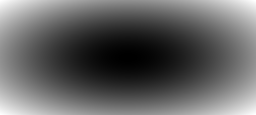

""

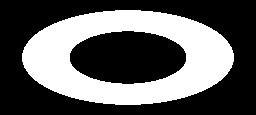

In [ ]:
media.show_image(distances.cpu().numpy())
media.show_image(image.cpu().numpy())